<a href="https://colab.research.google.com/github/KarlYang2013/tf_study/blob/master/tf_keras_to_estimator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0
sys.version_info(major=3, minor=7, micro=3, releaselevel='final', serial=0)
matplotlib 3.1.1
numpy 1.17.3
pandas 0.25.3
sklearn 0.21.3
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [ ]:
# https://storage.googleapis.com/tf-datasets/titanic/train.csv
# https://storage.googleapis.com/tf-datasets/titanic/eval.csv
train_file = "./data/titanic/train.csv"
eval_file = "./data/titanic/eval.csv"

train_df = pd.read_csv(train_file)
eval_df = pd.read_csv(eval_file)

print(train_df.head())
print(eval_df.head())

   survived     sex   age  n_siblings_spouses  parch     fare  class     deck  \
0         0    male  22.0                   1      0   7.2500  Third  unknown   
1         1  female  38.0                   1      0  71.2833  First        C   
2         1  female  26.0                   0      0   7.9250  Third  unknown   
3         1  female  35.0                   1      0  53.1000  First        C   
4         0    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  
   survived     sex   age  n_siblings_spouses  parch     fare   class  \
0         0    male  35.0                   0      0   8.0500   Third   
1         0    male  54.0                   0      0  51.8625   First   
2         1  female  58.0                   0      0  26.5500   First   
3         1  female  55.0                   0      0  16.0000  Second   
4         

In [ ]:
y_train = train_df.pop('survived')
y_eval = eval_df.pop('survived')

print(train_df.head())
print(eval_df.head())
print(y_train.head())
print(y_eval.head())

      sex   age  n_siblings_spouses  parch     fare  class     deck  \
0    male  22.0                   1      0   7.2500  Third  unknown   
1  female  38.0                   1      0  71.2833  First        C   
2  female  26.0                   0      0   7.9250  Third  unknown   
3  female  35.0                   1      0  53.1000  First        C   
4    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y  
      sex   age  n_siblings_spouses  parch     fare   class     deck  \
0    male  35.0                   0      0   8.0500   Third  unknown   
1    male  54.0                   0      0  51.8625   First        E   
2  female  58.0                   0      0  26.5500   First        C   
3  female  55.0                   0      0  16.0000  Second  unknown   
4    male  34.0                   0      0  13.0000  Second        D   

  

In [ ]:
train_df.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [ ]:
print(train_df.shape, eval_df.shape)

(627, 9) (264, 9)


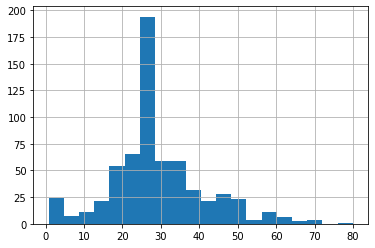

In [ ]:
train_df.age.hist(bins = 20)

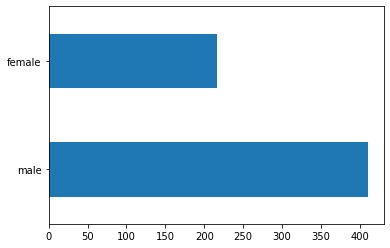

In [ ]:
train_df.sex.value_counts().plot(kind = 'barh')

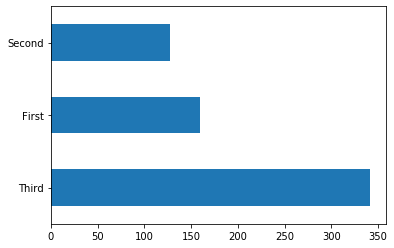

In [ ]:
train_df['class'].value_counts().plot(kind = 'barh')

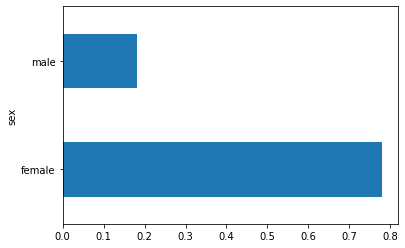

In [ ]:
pd.concat([train_df, y_train], axis = 1).groupby('sex').survived.mean().plot(kind='barh')

In [ ]:
categorical_columns = ['sex', 'n_siblings_spouses', 'parch', 'class',
                       'deck', 'embark_town', 'alone']
numeric_columns = ['age', 'fare']

feature_columns = []
for categorical_column in categorical_columns:
    vocab = train_df[categorical_column].unique()
    print(categorical_column, vocab)
    feature_columns.append(
        tf.feature_column.indicator_column(
            tf.feature_column.categorical_column_with_vocabulary_list(
                categorical_column, vocab)))

for categorical_column in numeric_columns:
    feature_columns.append(
        tf.feature_column.numeric_column(
            categorical_column, dtype=tf.float32))

sex ['male' 'female']
n_siblings_spouses [1 0 3 4 2 5 8]
parch [0 1 2 5 3 4]
class ['Third' 'First' 'Second']
deck ['unknown' 'C' 'G' 'A' 'B' 'D' 'F' 'E']
embark_town ['Southampton' 'Cherbourg' 'Queenstown' 'unknown']
alone ['n' 'y']


In [ ]:
def make_dataset(data_df, label_df, epochs = 10, shuffle = True,
                 batch_size = 32):
    dataset = tf.data.Dataset.from_tensor_slices(
        (dict(data_df), label_df))
    if shuffle:
        dataset = dataset.shuffle(10000)
    dataset = dataset.repeat(epochs).batch(batch_size)
    return dataset

In [ ]:
train_dataset = make_dataset(train_df, y_train, batch_size = 5)

In [ ]:
for x, y in train_dataset.take(1):
    print(x, y)

{'sex': <tf.Tensor: id=38, shape=(5,), dtype=string, numpy=array([b'male', b'female', b'male', b'male', b'male'], dtype=object)>, 'age': <tf.Tensor: id=30, shape=(5,), dtype=float64, numpy=array([36.,  5., 33., 39., 44.])>, 'n_siblings_spouses': <tf.Tensor: id=36, shape=(5,), dtype=int32, numpy=array([1, 2, 0, 0, 2], dtype=int32)>, 'parch': <tf.Tensor: id=37, shape=(5,), dtype=int32, numpy=array([2, 1, 0, 0, 0], dtype=int32)>, 'fare': <tf.Tensor: id=35, shape=(5,), dtype=float64, numpy=array([120.    ,  19.2583,   5.    ,  26.    ,  90.    ])>, 'class': <tf.Tensor: id=32, shape=(5,), dtype=string, numpy=array([b'First', b'Third', b'First', b'Second', b'First'], dtype=object)>, 'deck': <tf.Tensor: id=33, shape=(5,), dtype=string, numpy=array([b'B', b'unknown', b'B', b'unknown', b'C'], dtype=object)>, 'embark_town': <tf.Tensor: id=34, shape=(5,), dtype=string, numpy=
array([b'Southampton', b'Cherbourg', b'Southampton', b'Southampton',
       b'Queenstown'], dtype=object)>, 'alone': <tf.T

In [ ]:
# keras.layers.DenseFeature
for x, y in train_dataset.take(1):
    age_column = feature_columns[7]
    gender_column = feature_columns[0]
    print(keras.layers.DenseFeatures(age_column)(x).numpy())
    print(keras.layers.DenseFeatures(gender_column)(x).numpy())


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[22.]
 [28.]
 [27.]
 [29.]
 [21.]]

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base 

In [ ]:
# keras.layers.DenseFeature
for x, y in train_dataset.take(1):
    print(keras.layers.DenseFeatures(feature_columns)(x).numpy())


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[19.     0.     1.     0.     1.     0.     0.     0.     0.     0.
   1.     0.     0.     0.     1.     0.     0.     0.    30.     0.
   1.     0.     0.     0.     0.     0.     1.     0.     0.     0.
   0.     0.     0.     1.   ]
 [38.     0.     1.     0.     0.     1.     1.     0.     0.     0.
   0.     0.     0.     0.     1.     0.     0.     0.    13.     0.
   1.     0.     0.     0.     0.     0.     1.     0.     0.     0.
   0.     0.     0.     1.   ]
 [28.     0.     1.     0.     1

In [ ]:
model = keras.models.Sequential([
    keras.layers.DenseFeatures(feature_columns),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(2, activation='softmax'),
])
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = keras.optimizers.SGD(lr=0.01),
              metrics = ['accuracy'])


In [ ]:
# 1. model.fit 
# 2. model -> estimator -> train

train_dataset = make_dataset(train_df, y_train, epochs = 100)
eval_dataset = make_dataset(eval_df, y_eval, epochs = 1, shuffle = False)
history = model.fit(train_dataset,
                    validation_data = eval_dataset,
                    steps_per_epoch = 19,
                    validation_steps = 8,
                    epochs = 100)

Train for 19 steps, validate for 8 steps
Epoch 1/100
19/19 [==============================] - 0s 5ms/step - loss: 0.5530 - accuracy: 0.7237 - val_loss: 0.4954 - val_accuracy: 0.7617
Epoch 2/100
19/19 [==============================] - 0s 5ms/step - loss: 0.5141 - accuracy: 0.7484 - val_loss: 0.4875 - val_accuracy: 0.7656
Epoch 3/100
19/19 [==============================] - 0s 5ms/step - loss: 0.5058 - accuracy: 0.7714 - val_loss: 0.4928 - val_accuracy: 0.7969
Epoch 4/100
19/19 [==============================] - 0s 5ms/step - loss: 0.5225 - accuracy: 0.7549 - val_loss: 0.4861 - val_accuracy: 0.7461
Epoch 5/100
19/19 [==============================] - 0s 6ms/step - loss: 0.5407 - accuracy: 0.7451 - val_loss: 0.5659 - val_accuracy: 0.7109
Epoch 6/100
19/19 [==============================] - 0s 5ms/step - loss: 0.5172 - accuracy: 0.7599 - val_loss: 0.4897 - val_accuracy: 0.7422
Epoch 7/100
19/19 [==============================] - 0s 6ms/step - loss: 0.4947 - accuracy: 0.7648 - val_loss: 0.

19/19 [==============================] - 0s 4ms/step - loss: 0.5035 - accuracy: 0.7632 - val_loss: 0.4962 - val_accuracy: 0.7539
Epoch 59/100
19/19 [==============================] - 0s 6ms/step - loss: 0.4565 - accuracy: 0.7895 - val_loss: 0.4960 - val_accuracy: 0.8047
Epoch 60/100
19/19 [==============================] - 0s 6ms/step - loss: 0.4873 - accuracy: 0.7862 - val_loss: 0.4904 - val_accuracy: 0.7422
Epoch 61/100
19/19 [==============================] - 0s 5ms/step - loss: 0.5040 - accuracy: 0.7632 - val_loss: 0.5312 - val_accuracy: 0.7539
Epoch 62/100
19/19 [==============================] - 0s 6ms/step - loss: 0.4861 - accuracy: 0.7681 - val_loss: 0.4771 - val_accuracy: 0.7773
Epoch 63/100
19/19 [==============================] - 0s 6ms/step - loss: 0.4958 - accuracy: 0.7878 - val_loss: 0.4797 - val_accuracy: 0.7695
Epoch 64/100
19/19 [==============================] - 0s 6ms/step - loss: 0.4623 - accuracy: 0.8076 - val_loss: 0.4859 - val_accuracy: 0.7891
Epoch 65/100
19/19 

In [ ]:
estimator = keras.estimator.model_to_estimator(model)
# 1. function
# 2. return a. (features, labels) b. dataset -> (feature, label)
estimator.train(input_fn = lambda : make_dataset(
    train_df, y_train, epochs=100))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
Note that this doesn't affect the state of the model instance you passed as `keras_model` argument.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmppxevcovg', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f79741dca20>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_e

ValueError: Unexpectedly found an instance of type `<class 'dict'>`. Expected a symbolic tensor instance.